In [2]:
import numpy as np; import matplotlib.pyplot as plt
from matplotlib import colors
import random
import scipy
from scipy.integrate import solve_ivp

import sympy as sym
sym.init_printing()
#yo yo yo

In [3]:
# Recreation N-P-Z Model - Top Down Limitation
N_T = sym.symbols('N_T') #Total nutrients N + P + Z

N = sym.symbols('N')      # Nutrient supply
K_N = sym.symbols('K_N')  # K_N: is the Monod constant equivalent to the concentration of
                          #N at which the growth rate is half of its maximum value

P = sym.symbols('P')      # Phytoplankton population density
V_max = sym.symbols('V_max')  # Maximum phytoplankton growth rate
λ_P = sym.symbols('λ_P')  # Mortality & Respiration rate
μ_P = sym.symbols('μ_P')  # Remineralization fraction

Z = sym.symbols('Z')      # Zooplankton population density
g = sym.symbols('g')      # Maximum specific grazing rate
K_P = sym.symbols('K_P')  # Half-Saturation constant for grazing of P
γ_Z = sym.symbols('γ_Z')  # Growth rate / assimilation frequency
λ_Z = sym.symbols('λ_Z')  # Mortality & Respiration & Egestion
μ_Z = sym.symbols('μ_Z')  # Remineralization fraction
#yo yo yo hey

In [15]:
# Defining equations, from Sarmiento
def gamma_P(N, K_N):
    '''Monod growth function for specified nutrient.
       return: Monod (flt)
    '''
    return N / (K_N + N)

def grazing_func(p_pop_den, z_pop_den, grazing_rate, half_sat):
    ''' Grazing function, assuming we are in the linear portion of 
        the monod feeding curve.
        
        return: portion of the phytoplankton population lost to grazing (flt)
    '''
    return grazing_rate * (p_pop_den / half_sat) * z_pop_den


def Gamma_P(pop_den, max_growth_rate, nutr_monod_func, mortality, grazing_func):
    ''' Population density of Phytoplankton over time (steady state)'''
    paren = max_growth_rate * nutr_monod_func - mortality - (grazing_func / pop_den)
    return pop_den * paren

def Gamma_Z(pop_den, growth_rate, grazing_func, mortality):
    ''' Population density of Zooplankton over time (steady state)'''
    paren = growth_rate * (grazing_func / pop_den) - mortality
    return pop_den * paren

def Gamma_N(p_pop_den, max_growth, nutr_monod_func, p_remin, p_mort,
           z_pop_den, z_remin, z_assimilation, grazing_func, z_mort):
    
    '''Nutrient Supply Function'''
    
    from_phyto = p_pop_den * (-max_growth * nutr_monod_func + p_remin * p_mort)
    
    from_zoo_paren = (1 - z_assimilation) * (grazing_func / z_pop_den) + z_mort
    from_zoo = z_pop_den * z_remin * from_zoo_paren
    
    return from_phyto + from_zoo


In [16]:
#Defining equations symbolically with relavent variables
Γ_N = Gamma_N(P, V_max, gamma_P(N, K_N), μ_P, λ_P, Z, μ_Z, γ_Z, grazing_func(P, Z, g, K_P), λ_Z)

Γ_P = Gamma_P(P, V_max, gamma_P(N, K_N), λ_P, grazing_func(P, Z, g, K_P))

Γ_Z = Gamma_Z(Z, γ_Z, grazing_func(P, Z, g, K_P), λ_Z)

# Finding Steady-state solutions

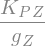

In [17]:
#Threshold for when P population is large enough to sustain Z population
P_sym = sym.solveset(Γ_Z, P) 
P_sym = P_sym.args[0]
P_sym

# Method 1: Find Z from Γ_P, Find N in terms of total nutrients.

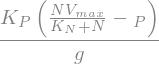

In [18]:
#Symbolically solving for Z from Gamma_P
Z_sym = sym.solveset(Γ_P, Z)

#Turning into usable function
Z_sol = sym.lambdify((N, K_N, V_max, λ_P, μ_P, g, K_P), Z_sym.args[0])
Z_sym = Z_sym.args[0]
Z_sym 

We know from $N_T = N + P + Z(N) \quad \Rightarrow \quad N + Z(N) + P - N_T = 0$


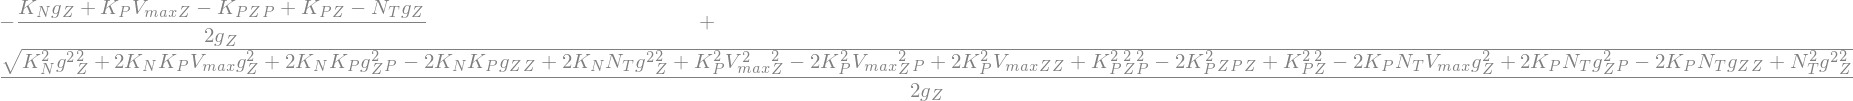

In [19]:
#Solving for N in terms of N_T 
N_sym = sym.solveset(N + Z_sym + P_sym - N_T, N)

#Turning into usable function, using positive branch of sol
N_sol = sym.lambdify((N_T, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), N_sym.args[0].args[1])
N_sym.args[0].args[1]

# Method 2: Find N from Γ_P, Find Z in terms of total nutrients

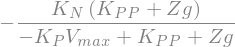

In [8]:
#Symbolically solving for N from Gamma_P
test = sym.solveset(Γ_P, N)

#Turning into usable function
test_sol = sym.lambdify((N, K_N, V_max, λ_P, μ_P, g, K_P), test.args[0])
test.args[0].args[0]

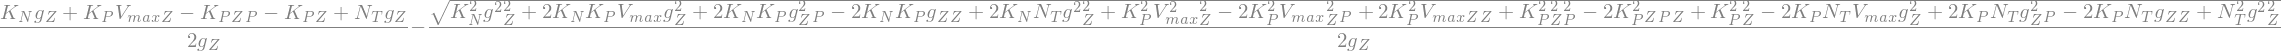

In [9]:
#Solving for Z in terms of N_T 
test2 = sym.solveset(test.args[0].args[0] + Z + P_sym - N_T, Z)

#Turning into usable function, using positive branch of sol
test2_sol = sym.lambdify((N_T, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), test2.args[0].args[0])
test2.args[0].args[0]

From the graphs below, the two methods seem to result in identical answers (as hoped). 

# Plotting 

In [20]:
#Plotting Regimes
def regime(N, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z):

    #N-Regime
    N_threshold = λ_P * K_N / (V_max - λ_P)
    
    if N < N_threshold: 
        N_n = N
        P, Z = 0, 0
        
        
    #N-P Regime
    else:
        P = N - N_threshold
        N_n = N - P
        P_threshold = (λ_Z * K_P) / (γ_Z * g)
        
        if P < P_threshold:
            Z = 0
        
        #N-P-Z Regime
        else:
            P = P_threshold
            
            N_n = N_sol(N, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)
            
            Z = Z_sol(N_n, K_N, V_max, λ_P, μ_P, g, K_P)
            
    return N_n, P, Z
    

#Args
K_N = .1    #mmol m^-3, the concentration of nutrients that supports a phytoplankton growthrate of V_max/2

V_max = 1.4 #d^-1
λ_P = .05   #d^-1
μ_P = .4

g = 1.4     #d^-1 
K_P = 2.8   #mmol m^-3, the concentration of phytoplankton that supports a grazing rate of g/2
γ_Z = .4
λ_Z = .12   #d^-1
μ_Z = .4

In [23]:
N_T = np.arange(0, 20, .04)

#Computing variable values
N = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[0] for i in range(len(N_T))]
P = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[1] for i in range(len(N_T))]
Z = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[2] for i in range(len(N_T))]

%store N
%store P
%store Z

P_Z_sum = [P[i] + Z[i] for i in range(len(N_T))]
N_P_Z_sum = [N[i] + P[i] + Z[i] for i in range(len(N_T))]

#Defining regime starting points
reg1 = [0 for i in range(len(N_T))]
reg2 = [.0037 for i in range(len(N_T))]
reg3 = [.6037 for i in range(len(N_T))]

Stored 'N' (list)
Stored 'P' (list)
Stored 'Z' (list)


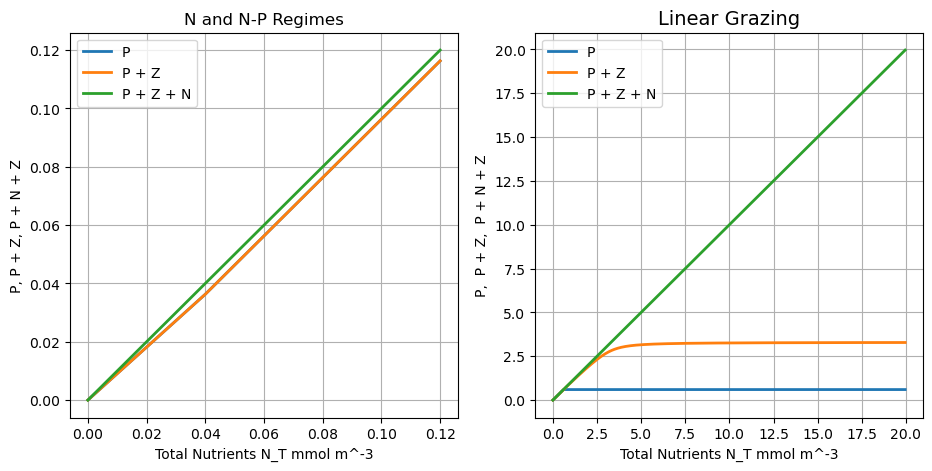

In [25]:
#Plotting
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#Zooming in to N and N-P regimes
stop = 4
ax.plot(N_T[:stop], P[:stop], linewidth = 2, label="P")
ax.plot(N_T[:stop], P_Z_sum[:stop], linewidth = 2, label="P + Z")
ax.plot(N_T[:stop], N_P_Z_sum[:stop], linewidth = 2, label="P + Z + N")

ax.set_xlabel("Total Nutrients N_T mmol m^-3")
ax.set_ylabel("P, P + Z, P + N + Z")
ax.set_title("N and N-P Regimes")

#N-P-Z
ax2.plot(N_T, P, linewidth = 2, label="P")
ax2.plot(N_T, P_Z_sum, linewidth = 2, label="P + Z")
ax2.plot(N_T, N_P_Z_sum, linewidth = 2, label="P + Z + N")

ax2.set_xlabel("Total Nutrients N_T mmol m^-3")
ax2.set_ylabel("P,  P + Z,  P + N + Z")
ax2.set_title("Linear Grazing", fontsize=14)


#Regime starting points
#ax.plot(reg1[:stop], N_T[:stop], label='N Regime begins')
#ax.plot(reg2[:stop], N_T[:stop], label='N-P Regime begins')
#ax2.plot(reg3, N_T, label='N-P-Z Regime begins')


ax.legend()
ax.grid()
ax2.legend()
ax2.grid()
plt.show()

In [16]:
for n in [0, .05, 1]:
    index = np.where(N_T == n)[0][0]
    print(f"For N_T = {n}")
    print(f"P = {P[index]}")
    print(f"Z = {Z[index]}")
    print()

For N_T = 0
P = 0
Z = 0

For N_T = 0.05
P = 0.0462962962962963
Z = 0

For N_T = 1
P = 0.6
Z = 0.3793444384266348



# Calculating Jacobian matrix

In [12]:
def calc_jacobian(nutr, phyto, zoo): 

    N_T = sym.symbols('N_T')
    N = sym.symbols('N')
    K_N = sym.symbols('K_N') 
    
    P = sym.symbols('P')
    V_max = sym.symbols('V_max')  
    λ_P = sym.symbols('λ_P')  
    μ_P = sym.symbols('μ_P')  
    
    Z = sym.symbols('Z')
    g = sym.symbols('g')  
    K_P = sym.symbols('K_P')  
    γ_Z = sym.symbols('γ_Z')  
    λ_Z = sym.symbols('λ_Z')  
    μ_Z = sym.symbols('μ_Z')  

    variables = [N_T, N, K_N, P, V_max, λ_P, μ_P, Z, g, K_P, γ_Z, λ_Z, μ_Z]

    #Calculating jacobian
    J = [[sym.diff(Γ_P, var) for var in variables], 
         [sym.diff(Γ_Z, var) for var in variables], 
         [sym.diff(Γ_N, var) for var in variables]]
    
    #Making inputs usable by scipy
    for i in range(3):
        for j in range(len(J[0])):
            J[i][j] = sym.lambdify((N_T, N, K_N, P, V_max, λ_P, μ_P, Z, g, K_P, γ_Z, λ_Z, μ_Z), J[i][j])
            J[i][j] = J[i][j](nutr + phyto + zoo, nutr, .1, phyto, 1.4, .05, .4, zoo, 1.4, 2.8, .4, .12, .4) #plugging in values
            
    return J

#Calculating singular values of system at different N_T levels in the system
points = [100, 3000, 6000, 20000, 40000, 60000] #N_T = .3, .6, 2, 4, 6 mmol m^-3
sensitivity = {}

for point in points:
    jacob = calc_jacobian(P[point], P_Z_sum[point], N_P_Z_sum[point]) #pulls data points at each value of N_T
    sensitivity[point] = scipy.linalg.svd(jacob, compute_uv=False), np.linalg.cond(jacob)

#printing results, nutrient level dependent on time step
for key in sensitivity:
    nutr_lvl = key * .0001
    sing_vals = [round(val, 3) for val in sensitivity[key][0]]
    cond_num = round(sensitivity[key][1], 3) #the larger the condition number, the more ill-conditioned the system
    
    print(f"Nutrient level: {nutr_lvl:4} mmol m^-3, Singular Values: {sing_vals}, Condition Number: {cond_num:5}")

Nutrient level: 0.01 mmol m^-3, Singular Values: [0.147, 0.106, 0.02], Condition Number: 7.412
Nutrient level:  0.3 mmol m^-3, Singular Values: [1.811, 0.324, 0.159], Condition Number: 11.376
Nutrient level:  0.6 mmol m^-3, Singular Values: [2.263, 0.673, 0.324], Condition Number: 6.975
Nutrient level:  2.0 mmol m^-3, Singular Values: [5.952, 3.101, 1.381], Condition Number: 4.309
Nutrient level:  4.0 mmol m^-3, Singular Values: [10.567, 8.205, 3.543], Condition Number: 2.982
Nutrient level:  6.0 mmol m^-3, Singular Values: [13.285, 12.423, 5.38], Condition Number: 2.469


# Sensitivity of key transport paremeters

In [13]:
#Random rgb tuple generator 
def rand_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

In [14]:
#Messing with grazing rate
grazing_rates = [.6, 1, 1.4, 1.8, 2.2]

#Creates a dictionary; Keys: grazing rates, Defs: regime solutions at rate
grazing_values = {}
for rate in grazing_rates:
    
    #Generating state variable values
    N = [regime(N_T[i], K_N, V_max, λ_P, μ_P, rate, K_P, γ_Z, λ_Z, μ_Z)[0] for i in range(len(N_T))]
    P = [regime(N_T[i], K_N, V_max, λ_P, μ_P, rate, K_P, γ_Z, λ_Z, μ_Z)[1] for i in range(len(N_T))]
    Z = [regime(N_T[i], K_N, V_max, λ_P, μ_P, rate, K_P, γ_Z, λ_Z, μ_Z)[2] for i in range(len(N_T))]

    #Generating sum as defined in Sermiento
    P_Z_sum = [P[i] + Z[i] for i in range(len(N_T))]
    N_P_Z_sum = [N[i] + P[i] + Z[i] for i in range(len(N_T))]
    
    grazing_values[rate] = (P, P_Z_sum, N_P_Z_sum, rand_color())

In [15]:
#Messing with V_max, phytoplankton max growth rate
p_growth_rates = [.6, .8, 1, 1.2, 1.4]

#Creates a dictionary; Keys: V_max, Defs: regime solutions at rate
growth_values = {}
for rate in p_growth_rates:
    
    #Generating state variable values
    N = [regime(N_T[i], K_N, rate, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[0] for i in range(len(N_T))]
    P = [regime(N_T[i], K_N, rate, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[1] for i in range(len(N_T))]
    Z = [regime(N_T[i], K_N, rate, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[2] for i in range(len(N_T))]

    #Generating sum as defined in Sermiento
    P_Z_sum = [P[i] + Z[i] for i in range(len(N_T))]
    N_P_Z_sum = [N[i] + P[i] + Z[i] for i in range(len(N_T))]

    growth_values[rate] = (P, P_Z_sum, N_P_Z_sum, rand_color())

In [16]:
#Messing with λ_P, phytoplankton mortality rate
p_mort_rates = [.02, .06, .1, .14, .18, .2]

#Creates a dictionary; Keys: mortality rates, Defs: regime solutions at spec. rate
mort_values = {}
for rate in p_mort_rates:
    
    #Generating state variable values
    N = [regime(N_T[i], K_N, V_max, rate, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[0] for i in range(len(N_T))]
    P = [regime(N_T[i], K_N, V_max, rate, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[1] for i in range(len(N_T))]
    Z = [regime(N_T[i], K_N, V_max, rate, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[2] for i in range(len(N_T))]

    #Generating sum as defined in Sermiento
    P_Z_sum = [P[i] + Z[i] for i in range(len(N_T))]
    N_P_Z_sum = [N[i] + P[i] + Z[i] for i in range(len(N_T))]

    mort_values[rate] = (P, P_Z_sum, N_P_Z_sum, rand_color())

In [17]:
#Messing with λ_Z, zooplankton mortality rate
z_mort_rates = [.02, .06, .1, .14, .18, .2]

#Creates a dictionary; Keys: mortality rates, Defs: regime solutions at spec. rate
z_mort_values = {}
for rate in z_mort_rates:
    
    #Generating state variable values
    N = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, rate, μ_Z)[0] for i in range(len(N_T))]
    P = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, rate, μ_Z)[1] for i in range(len(N_T))]
    Z = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, rate, μ_Z)[2] for i in range(len(N_T))]

    #Generating sum as defined in Sermiento
    P_Z_sum = [P[i] + Z[i] for i in range(len(N_T))]
    N_P_Z_sum = [N[i] + P[i] + Z[i] for i in range(len(N_T))]

    z_mort_values[rate] = (P, P_Z_sum, N_P_Z_sum, rand_color())

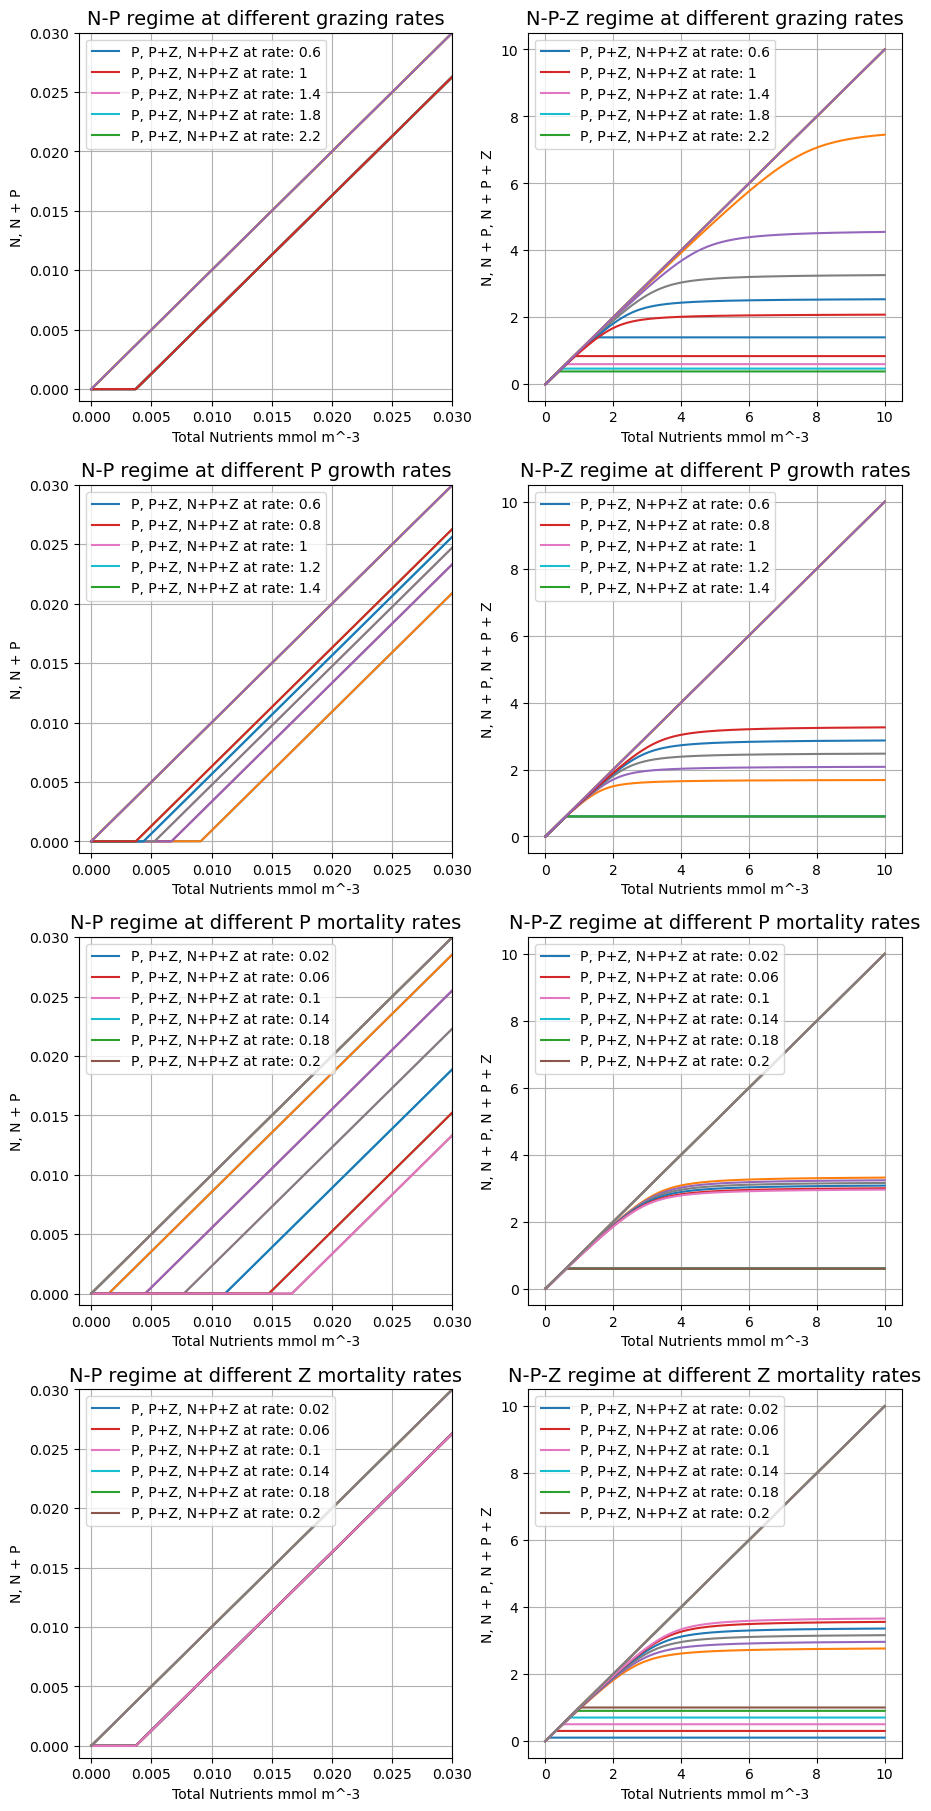

In [20]:
col_labels = ['grazing rates', 'P growth rates', 'P mortality rates', 'Z mortality rates']
sols = [grazing_values, growth_values, mort_values, z_mort_values]
fig = plt.figure(constrained_layout=True, figsize=(9, 18))

subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):
    
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):

        ax.set_xlabel('Total Nutrients mmol m^-3')
        
        sol = sols[row]
        for rate in sol:

            if col == 0: #N and N_P regimes
                ax.plot(N_T, sol[rate][0], linewidth = 1.5, label="P, P+Z, N+P+Z at rate: " + str(rate))
                ax.plot(N_T, sol[rate][1], linewidth = 1.5)
                ax.plot(N_T, sol[rate][2], linewidth = 1.5)
                
                ax.set_xlim([-.001, .03]); ax.set_ylim([-.001, .03])
                ax.set_ylabel('N, N + P')
                ax.set_title('N-P regime at different ' + str(col_labels[row]), fontsize = 14)

            else: #N_P_Z regimes
                ax.plot(N_T, sol[rate][0], linewidth = 1.5, label="P, P+Z, N+P+Z at rate: " + str(rate))
                ax.plot(N_T, sol[rate][1], linewidth = 1.5)
                ax.plot(N_T, sol[rate][2], linewidth = 1.5)

                ax.set_ylabel('N, N + P, N + P + Z')
                ax.set_title('N-P-Z regime at different ' + str(col_labels[row]), fontsize = 14)
                
        ax.legend(); ax.grid()




Smaller grazing rate yields larger nutrient portion towards phytoplankton and zooplankton population. This makes sense considering both steady state solutions are inversely proportional to grazing rate. However, it is counter intuative to assume a larger grazing rate would result in a smaller zooplankton population, but it makes sense larger grazing rates would dampen the phytoplankton population.

The smaller the grazing rate, the larger of an effect it has on the asymtote of the zooplankton pop dens. 

Variation in V_max only affects zooplankton curve. Larger P growth rates result in larger zooplankton pop; matches intuition. 

Variablitiy in phytoplankton mortality rates present miniscule change in the zooplanton curve, though the mort rates vary by small amounts. This makes sense, as in the zooplankton pop equation, the mortality rate of the phytoplankton essential shifts down the assymtote of the zooplankton curve.
Ths matches intuition, the higher the mortality rate of the phytoplankton, the more the zooplankton population growth is stunted.

The higher the mortality rate of the zooplankton, the larger the phytoplankton pop can grow. Looks like the same concentration of nutrients is held within the zooplankton biomass, disregarding the variablity in mortality. 